# The main body that contains the data loading, model defintion and model inference of the proposed T2C CNN

In [6]:
import os, shutil, csv
import pandas as pd
import numpy as np
import torch, math, random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings, os
import scipy.signal
import matplotlib.pyplot as plt
from torchvision import models
from scipy.ndimage import zoom
from itertools import cycle, zip_longest
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

train_domains = [1,2]
test_domains = [3,4]
image_size = 10
merge_event_gap = 10
event_per_group = 1000
index_suffix = '_linked'
regenerate = False
masked = True
photon_scaling = 500 # choose to normalize fluorescent spots within individule binding events if equal to 1
data_dir = './data/spots'
index_dir = './data/spots'
mask_suffix = '_subtracted' if masked else ''
# Set the experiments
random_seed = 42
fold = 0 # For spliting training set only
balance = False
min_train_measure, second_train_measure = 0, 0.1 # use all frames: 33, 20. Here, setting 0, 0.1 for test only
max_train_frame_idx = min_train_measure*60*10 + second_train_measure*10 # min*second*frame
min_test_measure, second_test_measure = 33, 20
max_test_frame_idx = min_test_measure*60*10 + second_test_measure*10 # min*second*frame
global_max_event_len = -2
print('fold:', fold)

# Set a seed for NumPy
np.random.seed(random_seed)

# Set a seed for Python's random module
random.seed(random_seed)

# Set a seed for PyTorch
torch.manual_seed(random_seed)

# Custom grouping function to ensure same "group" values are split together
def custom_group_split(df, random_seed, fold, min_train_group_num):
    groups = df['group'].unique()
    # Sample min_train_group_num groups
    groups = np.random.choice(groups, min_train_group_num, replace=False)
    
    # Shuffle the temp_groups array
    np.random.shuffle(groups)
    
    # Calculate the size of each subset
    subset_size = len(groups) // 5

    # Split temp_groups into four equal parts
    subset_1 = groups[:subset_size]
    subset_2 = groups[subset_size: 2*subset_size]
    subset_3 = groups[2*subset_size: 3*subset_size]
    subset_4 = groups[3*subset_size:4*subset_size]
    subset_5 = groups[4*subset_size:]
    
    # Verify the lengths of subsets
    print('Data subsets:', len(subset_1), len(subset_2), len(subset_3), len(subset_4), len(subset_5))
    
    all_subsets = [subset_1, subset_2, subset_3, subset_4, subset_5]
    val_groups = all_subsets[fold]
    train_groups = np.concatenate([all_subsets[i] for i in range(5) if i != fold])

    train_mask = df['group'].isin(train_groups)
    val_mask = df['group'].isin(val_groups)
    
    return df[train_mask], df[val_mask]

min_train_group_num = 1e6
for domain_idx in train_domains:
    unique_groups = set()
    index_path = f'{index_dir}/domain_{domain_idx}_indexes{index_suffix}.csv'
    index_df = pd.read_csv(index_path)
    index_df = index_df[index_df['frame']<max_train_frame_idx]
    # Get unique groups in the 'group' column
    unique_groups.update(index_df['group'].unique())
    # Count the number of unique groups
    num_unique_groups = len(unique_groups)
    if num_unique_groups < min_train_group_num:
        min_train_group_num = num_unique_groups
print('min_train_group_num:', min_train_group_num)

min_test_group_num = 1e6
for domain_idx in test_domains:
    unique_groups = set()
    index_path = f'{index_dir}/domain_{domain_idx}_indexes{index_suffix}.csv'
    index_df = pd.read_csv(index_path)
    index_df = index_df[index_df['frame']<max_test_frame_idx]
    # Get unique groups in the 'group' column
    unique_groups.update(index_df['group'].unique())
    # Count the number of unique groups
    num_unique_groups = len(unique_groups)
    if num_unique_groups < min_test_group_num:
        min_test_group_num = num_unique_groups
print('min_test_group_num:', min_test_group_num)

# Assuming you have a global DataFrame to store combined train, val, test sets
global_train_df = pd.DataFrame()
global_val_df = pd.DataFrame()
global_test_df = pd.DataFrame()
max_domain, max_group, max_frame = 0, 0, 0
for domain_idx, domain_name in enumerate(train_domains):
    train_path = f'{data_dir}/domain_{domain_name}/indexes/seed_{random_seed}/fold_{fold}/train.csv'
    val_path = f'{data_dir}/domain_{domain_name}/indexes/seed_{random_seed}/fold_{fold}/val.csv'
    index_path = f'{index_dir}/domain_{domain_name}_indexes{index_suffix}.csv'
    index_df = pd.read_csv(index_path)
    index_df = index_df[index_df['frame']<max_train_frame_idx]
    index_df['domain'] = domain_idx
    grouped = index_df.groupby(["domain", "group"])
    for (domain, group), group_df in grouped:
        last_frame, event_len = -merge_event_gap-1, 0
        group_df = group_df.sort_values(by='frame')
        group_df.reset_index(drop=True, inplace=True)
        for idx, row in group_df.iterrows():
            frame = int(row['frame'])
            # if domain == 1 and group == 122:
            #     print(f"[Domain: {domain}, group: {group}], {idx}/{len(group_df)}, {frame}/{last_frame}, {event_len}/{global_max_event_len}")
            if frame - last_frame > merge_event_gap:
                if event_len > global_max_event_len:
                    # print(f"Max event length found: {event_len} at Domain {domain}, group {group}, frame {frame}")
                    global_max_event_len = event_len
                    max_domain, max_group, max_frame = row['domain'], row['group'], row['frame']
                event_len = 1
            else:
                event_len += (frame - last_frame)
                if idx == len(group_df) - 1 and event_len > global_max_event_len:
                    global_max_event_len = event_len
                    max_domain, max_group, max_frame = row['domain'], row['group'], row['frame']
                    event_len = 0
            last_frame = frame
    
    # Split the DataFrame into train, val, and test sets using the custom grouping function
    train_df, val_df = custom_group_split(index_df, random_seed=random_seed, fold=fold, min_train_group_num=min_train_group_num)
    os.makedirs(os.path.dirname(train_path), exist_ok=True)
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    
    # Append to the global DataFrames
    global_train_df = pd.concat([global_train_df, train_df], ignore_index=True)
    global_val_df = pd.concat([global_val_df, val_df], ignore_index=True)
    
for domain_idx, domain_name in enumerate(test_domains):
    index_path = f'{index_dir}/domain_{domain_name}_indexes{index_suffix}.csv'
    index_df = pd.read_csv(index_path)
    index_df = index_df[index_df['frame']<max_test_frame_idx]
    index_df['domain'] = domain_idx
    if balance:
        groups = index_df['group'].unique()
        # Sample min_train_group_num groups
        test_groups = np.random.choice(groups, min_test_group_num, replace=False)
        test_mask = index_df['group'].isin(test_groups)
        index_df = index_df[test_mask]
    grouped = index_df.groupby(["domain", "group"])
    for (domain, group), group_df in grouped:
        last_frame, event_len = -merge_event_gap-1, 0
        group_df = group_df.sort_values(by='frame')
        group_df.reset_index(drop=True, inplace=True)
        for idx, row in group_df.iterrows():
            frame = row['frame']
            if frame - last_frame > merge_event_gap:
                if event_len > global_max_event_len:
                    global_max_event_len = event_len
                    max_domain, max_group, max_frame = row['domain'], row['group'], row['frame']
                event_len = 1
            else:
                event_len += (frame - last_frame)
                if idx == len(group_df) - 1 and event_len > global_max_event_len:
                    global_max_event_len = event_len
                    max_domain, max_group, max_frame = row['domain'], row['group'], row['frame']
                    event_len = 0
            last_frame = frame
            
    global_test_df = pd.concat([global_test_df, index_df], ignore_index=True)

global_max_event_len = int(global_max_event_len)
print(f'global_max_event_len: {global_max_event_len} at domain: {int(max_domain+1)}, group: {int(max_group)}, frame: {int(max_frame)}')
image_size_tuple = (global_max_event_len, image_size, image_size)
# Count the number of classes
num_classes = len(train_domains)
print(f'num_classes: {num_classes}')

# Define your dataset
class CustomDataset(Dataset):
    def __init__(self, df, num_event, max_frame_idx=20000, flag='test'):
        self.df = df#[:100] # For test the output dimension of conv layers
        self.num_event = num_event
        self.max_frame_idx = max_frame_idx
        self.flag = flag
        self.preprocess()
        self.pad_to_video()
        # Define frame-wise transformations if train for data augmentation
        self.frame_transform = transforms.Compose([
                transforms.RandomRotation(degrees=(0, 180))
            ])
            
    def preprocess(self):
        df = self.df
        self.data = []
        grouped = df.groupby(["domain", "group"])
        max_num_event = 0
        for (domain, group), group_df in grouped:
            grouped_df = group_df.sort_values(by='frame')
            domain_idx = test_domains[domain] if self.flag == 'test' else train_domains[domain]
            last_frame, events, event_counter, idx_in_event = -merge_event_gap-1, [], 0, 0
            for _, row in group_df.iterrows():
                frame, spot = int(row['frame']), int(row['spot'])
                if spot == -1:
                    continue
                patch_path = f"{data_dir}/domain_{domain_idx}/patches{mask_suffix}/frame_{frame + 1}/spot_{spot + 1}.tif"

                # Read the image in grayscale using PIL
                image = Image.open(patch_path)
                image_array = np.array(image).astype(np.float32)
                image_tensor = torch.from_numpy(image_array).unsqueeze(0)/photon_scaling

                # Get the current dimensions of the image tensor
                C, H, W = image_tensor.shape

                # Calculate padding on each side
                pad_left = max(0, (image_size - W) // 2)
                pad_right = max(0, image_size - W - pad_left)
                pad_top = max(0, (image_size - H) // 2)
                pad_bottom = max(0, image_size - H - pad_top)

                # Pad zeros to achieve the desired size
                image_tensor_padded = F.pad(image_tensor, (pad_left, pad_right, pad_top, pad_bottom), value=0)

                # Print the shape of the resulting tensor
                # print(image_tensor.shape, image_tensor_padded.shape) # torch.Size([1, 9, 10]) torch.Size([1, 10, 10])

                # new binding events
                complete = 1 if frame < self.max_frame_idx - 1 else 0
                value_to_append = {'patches': [image_tensor_padded], 'labels': [torch.tensor(domain).long().unsqueeze(0)], 'groups': [torch.tensor(group).long().unsqueeze(0)], 'events': [torch.tensor(event_counter).long().unsqueeze(0)], 'completes': [torch.tensor(complete).unsqueeze(0)]}
                if frame - last_frame > merge_event_gap: 
                    event_counter += 1
                    if event_counter <= self.num_event:
                        events.append(value_to_append)
                        idx_in_event = 0
                        # if domain == 1 and int(group) == 530 or idx_in_event > global_max_event_len: # 
                        #     print(f'domain: {domain}, group: {group}, frame {frame}, last frame: {last_frame}, idx_in_event: {idx_in_event}')                            
                        events[-1]['idxes'] = [torch.tensor(idx_in_event).long().unsqueeze(0)]
                    if event_counter > self.num_event:
                        break # break to next group
                    if event_counter > max_num_event:
                        max_num_event = event_counter
                elif event_counter <= self.num_event:
                    frame_skip = frame - last_frame - 1
                    if frame_skip > 0:
                        missed_value_to_append = {'patches': [torch.zeros_like(image_tensor_padded)], 'labels': [torch.tensor(domain).long().unsqueeze(0)], 'groups': [torch.tensor(group).long().unsqueeze(0)], 'events': [torch.tensor(event_counter).long().unsqueeze(0)], 'completes': [torch.tensor(complete).unsqueeze(0)]}
                        for skiped_frame in range(frame_skip):
                            idx_in_event += 1
                            # if domain == 1 and int(group) == 530 or idx_in_event > global_max_event_len: # 
                            #     print(f'domain: {domain}, group: {group}, frame {frame}, last frame: {last_frame}, idx_in_event: {idx_in_event}')
                            for key, value in missed_value_to_append.items():
                                events[-1][key].extend(value)
                            events[-1]['idxes'].append(torch.tensor(idx_in_event).long().unsqueeze(0))
                    idx_in_event += 1
                    # if domain == 1 and int(group) == 530 or idx_in_event > global_max_event_len: # 
                    #     print(f'domain: {domain}, group: {group}, frame {frame}, last frame: {last_frame}, idx_in_event: {idx_in_event}')
                    for key, value in value_to_append.items():
                        events[-1][key].extend(value)
                    events[-1]['idxes'].append(torch.tensor(idx_in_event).long().unsqueeze(0))

                last_frame = frame
            
            self.data.append(events)
        print('max_num_event:', max_num_event)
    
    def pad_to_video(self):
        self.video, self.frames = [], []
        for events in self.data:
            for event in events:
                patches, labels, groups, events, idxes, completes = event['patches'], event['labels'], event['groups'], event['events'], event['idxes'], event['completes']
                if completes[-1]:
                    video = torch.stack(patches, dim=1)
                    valid_frames = video.size(1)
                    self.frames.append(valid_frames)
                    if photon_scaling == 1:
                        mean = torch.mean(video)
                        std = torch.std(video)
                        # Normalize the tensor
                        video = (video - mean) / std
                    # print('before pad:', video.shape) # before pad: torch.Size([1, 8, 10, 10])
                    video = F.pad(video, (0, 0, 0, 0, 0, global_max_event_len - valid_frames), value=0)
                    # print('after pad:', video.shape) # after pad: torch.Size([1, 449, 10, 10])
                    
                    # video for individual binding events
                    video_dict = {'frames': torch.tensor(valid_frames).long().unsqueeze(0), 'video': video, 'label': labels[0], 'group': groups[0], 'event': events[0]}
                    self.video.append(video_dict)
            
    def __len__(self):
        return len(self.video)

    def __getitem__(self, idx):
        return self.video[idx]


class Custom3DConvNet(nn.Module):
    def __init__(self, num_classes, image_size_tuple, hidden_dim=64, bias=True):
        super(Custom3DConvNet, self).__init__()

        self.D, self.H, self.W = image_size_tuple
        self.slice_len = 512
        self.hidden_dim = hidden_dim
        input_channel = self.slice_len
         # Custom convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, hidden_dim, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(5, 5), stride=(5, 5), padding=(0, 0), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(2*hidden_dim, hidden_dim, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0), bias=bias),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU()
        )

        # Pooling layers
        self.pool = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.temporal_pool = nn.AvgPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(3*hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.02)

    def forward(self, x, frames, frame_mask_start_fraction=None, stage='test'):
        batch_size, channels, num_frames, height, width = x.size()
        
        # Drop the channel dim with just 1 channel
        x = x.squeeze(1)
        x_input = x

        # slice input
        sliced_x, slice_indexes, slice_template = torch.tensor([]).to(device), [], torch.zeros(self.slice_len, x.size(2), x.size(3)).to(device)
        for i, frame in enumerate(frames):
            cat_times = 0
            if (frame_mask_start_fraction is not None) and frame >= 10:
                frame_mask_start_idx = int(frame_mask_start_fraction * frame)
                frame_mask_end_idx = int((frame_mask_start_fraction + 0.1) * frame) # Default interval: 0.1
                remaining_x_values_sum = x[i, :frame_mask_start_idx].sum() + x[i, frame_mask_end_idx:].sum() if frame_mask_start_fraction != 0.9 else x[i, :frame_mask_start_idx].sum()
                if remaining_x_values_sum > 0: # aviod nan values
                    x[i, frame_mask_start_idx: frame_mask_end_idx] = 0
                    if frame_mask_start_fraction == 0.9:
                        frame = frame_mask_start_idx
            slice_times = math.ceil(frame / self.slice_len)
            remaining = frame % self.slice_len
            if slice_times < 1:
                print(f'slice_times: {slice_times}, frame: {frame}')
            slice_indexes.append(slice_times)
            for s in range(slice_times-1):
                one_slice = x[i, s*self.slice_len: (s+1)*self.slice_len].unsqueeze(0)
                sliced_x = torch.cat((sliced_x, one_slice), dim=0)
                cat_times += 1
            s = slice_times-1
            last_slice = slice_template
            video_to_slice = x[i, s*self.slice_len:frame]
            end = remaining if remaining > 0 else self.slice_len
            last_slice[:end] = video_to_slice
            sliced_x = torch.cat((sliced_x, last_slice.unsqueeze(0)), dim=0)
            cat_times += 1
            if cat_times != slice_times:
                print(f'unmatched slice_times: {slice_times} and cat_times: {cat_times} for frame: {frame} and frames[i]: {frames[i]}')

        # add random noise
        # if stage in ['train']:
        #     sliced_x += 0.02 * torch.poisson(torch.round(photon_scaling*(F.relu(sliced_x))))/photon_scaling
        
        # Apply custom convolutional layers with ReLU activation, batch normalization, and pooling
        x = self.conv1(sliced_x)
        x = torch.cat((self.conv2(x), x), dim=1)
        x = torch.cat((self.conv3(x), x), dim=1)
        
        # Drop height and width dim with 1 x 1 size
        embedding = x.squeeze(-1).squeeze(-1)
        
        # Apply fully connected layers with ReLU activation, batch normalization, and dropout
        x = self.fc(embedding)
        output_x = torch.zeros_like(x[:batch_size])
        if torch.isnan(output_x).any():
            print(f'output_x (before adding): {output_x}')
        mask = torch.zeros_like(output_x)
        mask[0] = 1
        value_to_add = x[:slice_indexes[0]]
        output_x = output_x + mask * value_to_add.mean(0).unsqueeze(0) * torch.ones_like(output_x)
        if torch.isnan(output_x).any() or torch.isnan(value_to_add).any():
            print(f'output_x (after first-time adding): {output_x}')
            print(f'i: {0}, slice_indexes: {slice_indexes}, start: {start}, end: {end}')
            print(f'value_to_add: {value_to_add}, embedding[start:end]: {embedding[:slice_indexes[0]]}, sliced_x[start:end]: {sliced_x[:slice_indexes[0]]}, x_input[0]: {x_input[0]}, frames[0]: {frames[0]}')
        for i in range(1, batch_size):
            mask = torch.zeros_like(output_x)
            mask[i] = 1
            start = sum(slice_indexes[:i])
            end = sum(slice_indexes[:i+1])
            value_to_add = x[start:end]
            output_x = output_x + mask * value_to_add.mean(0).unsqueeze(0) * torch.ones_like(output_x)
                
            if torch.isnan(value_to_add).any() or torch.isnan(output_x).any():
                print(f'output_x (after {i}th-time adding): {output_x}')
                print(f'i: {i}, slice_indexes: {slice_indexes}, start: {start}, end: {end}')
                print(f'len(slice_indexes): {len(slice_indexes)}, len(sliced_x): {len(sliced_x)}, len(embedding): {len(embedding)}, len(x_input): {len(x_input)}, len(frames): {len(frames)}')
                print(f'value_to_add: {value_to_add}, embedding[start:end]: {embedding[start:end]}, sliced_x[start:end]: {sliced_x[start:end]}, x_input[i]: {x_input[i]}, frames[i]: {frames[i]}')
                
        return output_x


# Check if GPU is available and move model and data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")    

# Instantiate the model
model = Custom3DConvNet(num_classes, image_size_tuple).to(device)

# Create DataLoader for testing
batch_size = 512
test_dataset = CustomDataset(global_test_df, num_event=event_per_group)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')
print(f'Test: {len(test_dataset)}')

# Define consistency loss function using mean squared error
def consistency_loss(output_val_, group_val, confident_rate=0.9, train=False):
    output_val = F.softmax(output_val_, dim=-1)
    unique_groups, group_indices = torch.unique(group_val, return_inverse=True)
    group_means = torch.zeros_like(output_val)

    for i in range(len(unique_groups)):
        mask = (group_val == unique_groups[i]).float().view(-1, 1)
        current_group_mean = output_val[group_indices == i].mean(dim=0)
        group_means += mask * current_group_mean
        # if torch.isnan(current_group_mean).any():
        #     print(f'i: {i}, unique_groups[i]: {unique_groups[i]}, mask: {mask}, current_group_mean: {current_group_mean}, group_means: {group_means}, output_val[group_indices == i]: {output_val[group_indices == i]}, mask.sum(): {mask.sum()}')

    # loss = F.mse_loss(output_val, group_means)
    # Calculate KL divergence
    loss = F.kl_div(output_val.log(), group_means, reduction='batchmean')

    return loss, group_means

def event_filter(all_unique_groups, num_event, all_predictions_test, all_labels_test):
    unique_values, unique_indices = torch.unique(all_unique_groups, return_inverse=True)
    first_indexes, max_event_num = [], 0
    for value in unique_values:
        indices = (all_unique_groups == value).nonzero().squeeze(1)
        if indices.numel() > max_event_num:
            max_event_num = indices.numel()
        if indices.numel() > num_event:
            indices = indices[:num_event]
        first_indexes.extend(indices)
    print('max_event_num:', max_event_num)
    first_indexes = [tensor.item() for tensor in first_indexes]
    return all_predictions_test[first_indexes], all_labels_test[first_indexes].tolist(), all_unique_groups[first_indexes]


def reduced_by_group(predictions, labels, groups):
    unique_groups, group_indices = torch.unique(groups, return_inverse=True)
    reduced_predictions, reduced_labels = [], []
    for i in range(len(unique_groups)):
        one_group_indices = [j for j in range(len(group_indices)) if group_indices[j] == i]
        prediction = [predictions[j] for j in one_group_indices][0]
        label = [labels[j] for j in one_group_indices][0]
        reduced_predictions.append(prediction)
        reduced_labels.append(label)
    return reduced_predictions, reduced_labels

def save_results(num_event, frame_mask_start_fraction, per_class_accuracies_consistent, per_class_accuracies, per_class_accuracies_reduced_by_group, model_save_token, all_labels, all_groups, all_event_lens, all_predictions_consistent, all_predictions, all_predict_logits_test):
    mask_str = f'No_Mask' if frame_mask_start_fraction is None else f'Mask_{100*frame_mask_start_fraction:.2f}%~{100*(frame_mask_start_fraction+0.1):.2f}%'
    formatted_accuracies_consistent = [f"{acc * 100:.2f}%" for acc in per_class_accuracies_consistent]
    formatted_accuracies = [f"{acc * 100:.2f}%" for acc in per_class_accuracies]
    formatted_accuracies_reduced_by_group = [f"{acc * 100:.2f}%" for acc in per_class_accuracies_reduced_by_group]
    filename = f"./results/test_predictions/{model_save_token}/{mask_str}_#{num_event}_events_{formatted_accuracies_consistent}.csv"
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Label', 'Group', 'Event_Length', 'Prediction', 'Consistent_Prediction'] + [f'Class_{i+1}_Prob' for i in range(num_classes)])
        for label, group, event_len, prediction, prediction_consistent, predict_logits_test in zip(all_labels, all_groups, all_event_lens, all_predictions, all_predictions_consistent, all_predict_logits_test):
            writer.writerow([label, int(group.item()-1e6*label), event_len.item(), prediction, prediction_consistent] + [predict_logits_test[i].item() for i in range(num_classes)])
      
def test(model, loader, num_event=1, frame_mask_start_fraction=None, save_preditons=True):
    model.eval()
    # print(model)
    desired_domain_idx, visual_idx, init_falg = 0, 0, True
    all_predictions_test, all_labels_test, all_groups_test, all_frames_test = [], [], [], []
    with torch.no_grad():
        for batch_test in tqdm(loader):
            video_test, labels_test, groups_test, events_test, frames_test = batch_test['video'].to(device), batch_test['label'].squeeze().to(device), batch_test['group'].squeeze().to(device), batch_test['event'].squeeze().to(device), batch_test['frames']
            # print(f'labels_test: {labels_test}, groups_test: {groups_test}, events_test: {events_test}, frames_test: {frames_test}, video_test.shape: {video_test.shape}, video_test[0]: {video_test[0]}')
            outputs_test = model(video_test, frames_test, frame_mask_start_fraction=frame_mask_start_fraction, stage='train')
            # print(f'logits: {torch.nn.Softmax(dim=-1)(outputs_test)}')
            if init_falg:
                all_predictions_test = outputs_test
                init_falg = False
            else:
                all_predictions_test = torch.cat((all_predictions_test, outputs_test), dim=0)
            if len(frames_test) == 1:
                all_labels_test.append(labels_test.cpu().numpy())
                all_groups_test.append(groups_test.cpu().numpy())
                all_frames_test.append(frames_test.cpu())
            else:
                all_labels_test.extend(labels_test.cpu().numpy())
                all_groups_test.extend(groups_test.cpu().numpy())
                all_frames_test.extend(frames_test.cpu())
        all_unique_groups = [domain*1e6+group for domain, group in zip(all_labels_test, all_groups_test)]
        all_unique_groups = torch.tensor(all_unique_groups).to(device)
        # all_predictions_test, all_labels_test, all_unique_groups = event_filter(all_unique_groups, num_event, all_predictions_test, torch.tensor(all_labels_test).to(device))
        _, all_predictions_test_consistent = consistency_loss(all_predictions_test, all_unique_groups, train=False)
        # print(all_predictions_test_consistent)
        all_predict_logits_test = torch.nn.Softmax(dim=-1)(all_predictions_test).cpu().numpy()
        all_predictions_test = torch.argmax(all_predictions_test, dim=-1).tolist()
        all_predictions_test_consistent = torch.argmax(all_predictions_test_consistent, dim=-1).tolist()
        # all_predictions_test_reduced_by_group, all_labels_test_reduced_by_group = reduced_by_group(all_predictions_test_consistent, all_labels_test, all_unique_groups)
        
    # Calculate accuracy on the test sets
    # print('Number of test events:', len(all_labels_test))
    test_events = len(all_labels_test)
    accuracy_test_consistent = accuracy_score(all_labels_test, all_predictions_test_consistent)
    # accuracy_test_reduced_by_group = accuracy_score(all_labels_test_reduced_by_group, all_predictions_test_reduced_by_group)
    accuracy_test = accuracy_score(all_labels_test, all_predictions_test)
    # Calculate the confusion matrix
    conf_matrix_consistent = confusion_matrix(all_labels_test, all_predictions_test_consistent)
    # conf_matrix_reduced_by_group = confusion_matrix(all_labels_test_reduced_by_group, all_predictions_test_reduced_by_group)
    conf_matrix = confusion_matrix(all_labels_test, all_predictions_test)
    # Calculate per-class accuracies
    per_class_accuracies_consistent, per_class_accuracies_reduced_by_group = [0], [0]
    per_class_accuracies_consistent = conf_matrix_consistent.diagonal() / conf_matrix_consistent.sum(axis=1)
    # per_class_accuracies_reduced_by_group = conf_matrix_reduced_by_group.diagonal() / conf_matrix_reduced_by_group.sum(axis=1)
    per_class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    per_class_groups = 0
    # per_class_groups = conf_matrix_reduced_by_group.sum(axis=1)
    per_class_events = conf_matrix.sum(axis=1)
    if save_preditons:
        save_results(num_event, frame_mask_start_fraction, per_class_accuracies_consistent, per_class_accuracies, per_class_accuracies_reduced_by_group, model_save_token, all_labels_test, all_unique_groups, all_frames_test, all_predictions_test_consistent, all_predictions_test, all_predict_logits_test)
    return per_class_accuracies_consistent, per_class_accuracies_reduced_by_group, per_class_accuracies, per_class_groups, per_class_events, test_events


fold: 0
min_train_group_num: 27
min_test_group_num: 1736
Data subsets: 5 5 5 5 7
Data subsets: 5 5 5 5 7
global_max_event_len: 217 at domain: 2, group: 408, frame: 9761
num_classes: 2
Using device: cuda
max_num_event: 34
Test: 29241


# Ablation study on the importance of test frames in every binding events, including no mask (model inference)

In [ ]:
model_idx = 4
model_read_token = ['best_model_CNN_row_image_patches_temporal2channel-Copy2',
                    '90.36_fold_1/best_model_CNN_row_image_patches_temporal2channel-Copy3',
                    '95.46%_fold_4/best_model_CNN_row_image_patches_temporal2channel-Copy3',
                    '93.80%_fold_1/best_model_CNN_mixed_row_image_patches_temporal2channel',
                    '91.69%_fold_3/best_model_CNN_mixed_row_image_patches_temporal2channel-Copy2'
                   ][model_idx]
model_save_token = ['best_model_CNN_row_image_patches_temporal2channel-Fold1',
                    'linked/best_model_CNN_row_image_patches_temporal2channel-Fold1',
                    'linked/best_model_CNN_row_image_patches_temporal2channel-Fold4',
                    'linked/mixed/best_model_CNN_mixed_row_image_patches_temporal2channel-Fold1',
                    'linked/mixed/normalized/best_model_CNN_mixed_row_image_patches_temporal2channel-Fold3'
                   ][model_idx]
best_model_path = [f'./model/reported/5_6_domain/class_balanced/test_7_8/subtracted/train_all/sliced/fold_3/improved/83.55%_weight_decay=1e-5/85.66%_fold_1/{model_read_token}.pth',
                   f'./model/reported/5_6_domain/class_balanced/test_7_8/subtracted/sliced/linked/{model_read_token}.pth',
                   f'./model/reported/5_6_domain/class_balanced/test_7_8/subtracted/sliced/linked/{model_read_token}.pth',
                   f'./model/reported/5_6_domain/class_balanced/test_7_8/subtracted/sliced/linked/mixed/{model_read_token}.pth',
                   f'./model/reported/5_6_domain/class_balanced/test_7_8/subtracted/sliced/linked/mixed/normalized/{model_read_token}.pth'
                   ][model_idx]

# Instantiate the model
model = Custom3DConvNet(num_classes, image_size_tuple).to(device)

# Load the best model for testing
model.load_state_dict(torch.load(best_model_path))
# print(model)
model.eval()

save_preditons = True
per_class_test_accuracies, per_class_test_accuracies_consistent, per_class_test_accuracies_reduced_by_group, per_class_test_groups, per_class_test_events, num_test_events = [], [], [], [], [], []
frame_fractions = [None] #+ np.arange(0, 1, 0.1).tolist()
for frame_mask_start_fraction in frame_fractions:
    per_class_accuracies_consistent, per_class_accuracies_reduced_by_group, per_class_accuracies, per_class_groups, per_class_events, test_events = test(model, test_loader, num_event=event_per_group, frame_mask_start_fraction=frame_mask_start_fraction, save_preditons=save_preditons)
    per_class_test_accuracies.append([round(acc * 100, 2) for acc in per_class_accuracies])
    per_class_test_accuracies_consistent.append([round(acc * 100, 2) for acc in per_class_accuracies_consistent])
    per_class_test_accuracies_reduced_by_group.append([round(acc * 100, 2) for acc in per_class_accuracies_reduced_by_group])
    per_class_test_groups.append(per_class_groups)
    per_class_test_events.append(per_class_events)
    num_test_events.append(str(int(test_events)))
    if frame_mask_start_fraction is None:
        print(f'No mask')
    else:
        print(f'Masked frame fraction: {100*frame_mask_start_fraction:.2f}%~{100*(frame_mask_start_fraction+0.1):.2f}%')
    formatted_accuracies_consistent = [f"{acc * 100:.2f}%" for acc in per_class_accuracies_consistent]
    formatted_accuracies = [f"{acc * 100:.2f}%" for acc in per_class_accuracies]
    formatted_accuracies_reduced_by_group = [f"{acc * 100:.2f}%" for acc in per_class_accuracies_reduced_by_group]
    print(f"Test groups in each domain: {per_class_groups}")
    print(f"Test events in each domain: {per_class_events}")
    print(f"Test Accuracy on all frames (w/o consistency): {formatted_accuracies}")
    print(f"Test Accuracy on all frames (reduced by group): {formatted_accuracies_reduced_by_group}")
    print(f"Test Accuracy on all frames: {formatted_accuracies_consistent}")

print(f'event_per_group = {event_per_group}')
print(f'frame_fractions = {frame_fractions}')
print(f"Test groups in each domain: {per_class_test_groups}")
print(f"Test events in each domain: {per_class_test_events}")
print(f'per_class_test_accuracies = {per_class_test_accuracies}')
print(f'per_class_test_accuracies_consistent = {per_class_test_accuracies_consistent}')
print(f'per_class_test_accuracies_reduced_by_group = {per_class_test_accuracies_reduced_by_group}')

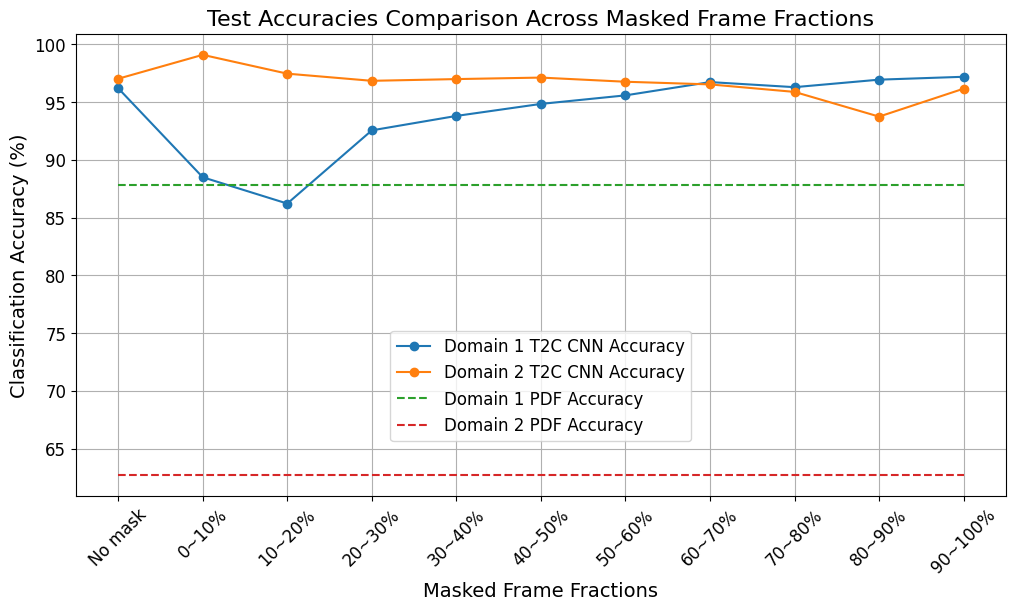

In [3]:
import matplotlib.pyplot as plt
import os

# Data
model_save_token = 'linked/best_model_CNN_row_image_patches_temporal2channel-Fold1'
frame_fractions = ['No mask', '0~10%', '10~20%', '20~30%', '30~40%', '40~50%', '50~60%', '60~70%', '70~80%', '80~90%', '90~100%']
per_class_test_accuracies = per_class_test_accuracies_consistent
per_class_test_accuracies_list = [[acc[i] for acc in per_class_test_accuracies] for i in range(len(per_class_test_accuracies[0]))]
per_class_test_accuracies_pdf = [87.82, 62.72]
per_class_test_accuracies_pdf_list = [[per_class_test_accuracies_pdf[i]]*len(per_class_test_accuracies) for i in range(len(per_class_test_accuracies[0]))]

# Plotting
plt.figure(figsize=(12, 6))

# Plot per-class test accuracies
for i, class_accuracies in enumerate(per_class_test_accuracies_list):
    plt.plot(frame_fractions, class_accuracies, marker='o', label=f'Domain {i+1} T2C CNN Accuracy')

# Plot per-class test accuracies PDF
for i, class_pdf_accuracies in enumerate(per_class_test_accuracies_pdf_list):
    plt.plot(frame_fractions, class_pdf_accuracies, linestyle='--', label=f'Domain {i+1} PDF Accuracy')

# Adding title and labels with larger font sizes
plt.title('Test Accuracies Comparison Across Masked Frame Fractions', fontsize=16)
plt.xlabel('Masked Frame Fractions', fontsize=14)
plt.ylabel('Classification Accuracy (%)', fontsize=14)
plt.legend(bbox_to_anchor=(0.5, 0.1), loc='lower center', fontsize=12)  # Use bbox_to_anchor and loc for legend position
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Save the figure
# model_save_token = 'your_model_save_token_here'  # Replace with actual model_save_token
save_path = f"./results/test_predictions/{model_save_token}/mask_comparison.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, bbox_inches='tight')

# Show the plot
plt.show()


### Visualize frame correlations

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming `global_test_df` and other necessary variables are already defined

def compute_frame_correlations(dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    num_frames = dataset[0]['video'].shape[1]
    correlations = {0: torch.zeros(num_frames, num_frames), 1: torch.zeros(num_frames, num_frames)}
    counters = {0: torch.zeros(num_frames, num_frames, dtype=torch.int), 1: torch.zeros(num_frames, num_frames, dtype=torch.int)}
    max_frame_nums = {0: 0, 1: 0}
    
    for data in tqdm(loader):
        video = data['video'].squeeze(0).squeeze(0)  # (batch_size=1, channels=1, num_frames, H, W)
        label = data['label'].item()
        frame = data['frames'].item()
    
        # Flatten the frames and compute correlation matrix
        num_frames, H, W = video.shape
        flattened_frames = video[:frame].view(frame, -1).numpy()  # (frame, H*W)
    
        # Identify rows with all zero elements
        zero_rows = np.all(flattened_frames == 0, axis=1)
        zero_indices = np.where(zero_rows)[0]
    
        # Initialize the correlation matrix with zeros
        correlation_matrix = np.zeros((frame, frame))
    
        # Compute the correlation matrix only for non-zero frames
        if len(zero_indices) < frame-1:
            non_zero_indices = np.where(~zero_rows)[0]
            non_zero_frames = flattened_frames[non_zero_indices, :]
            correlations[label][np.ix_(non_zero_indices, non_zero_indices)] += torch.from_numpy(np.corrcoef(non_zero_frames))
            counters[label][np.ix_(non_zero_indices, non_zero_indices)] += 1
    
        # Update correlations and counters
        if frame > max_frame_nums[label]:
            max_frame_nums[label] = frame

    for label, matrices in correlations.items():
        correlations[label] = correlations[label][:max_frame_nums[label], :max_frame_nums[label]]
        counters[label] = counters[label][:max_frame_nums[label], :max_frame_nums[label]]
    
    return correlations, counters

def average_correlation_matrices(correlations, counters):
    averaged_correlations = {}
    for label, matrices in correlations.items():
        averaged_correlations[label] = matrices / (counters[label]+1e-6)
    return averaged_correlations

def save_averaged_correlations(averaged_correlations, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'averaged_correlations.pt')
    torch.save(averaged_correlations, save_path)
    print(f'Saved averaged correlations to {save_path}')

def load_averaged_correlations(save_dir):
    save_path = os.path.join(save_dir, 'averaged_correlations.pt')
    if os.path.exists(save_path):
        averaged_correlations = torch.load(save_path)
        print(f'Loaded averaged correlations from {save_path}')
        return averaged_correlations
    else:
        return None

def visualize_correlations(correlations, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    # Set font sizes
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'axes.titlesize': 18})
    plt.rcParams.update({'axes.labelsize': 16})
    plt.rcParams.update({'legend.fontsize': 14})
    plt.rcParams.update({'xtick.labelsize': 14})
    plt.rcParams.update({'ytick.labelsize': 14})
    
    # Determine the global min and max values for the colorbar
    global_vmin = min(correlations[0].min().item(), correlations[1].min().item())
    global_vmax = max(correlations[0].max().item(), correlations[1].max().item())
    print(f'global_vmin: {global_vmin}, global_vmax: {global_vmax}')
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    labels = [0, 1]
    titles = ['Domain 1', 'Domain 2']
    
    for ax, label, title in zip(axes, labels, titles):
        sns.heatmap(correlations[label], ax=ax, vmin=global_vmin, vmax=global_vmax, cmap='coolwarm', square=True, cbar_kws={'shrink': .75})
        ax.set_title(f'Average Frame Correlation - {title}')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Frame')
    
    plt.tight_layout()
    plt_path = os.path.join(save_dir, 'frame_correlations.png')
    plt.savefig(plt_path)
    plt.close()
    print(f'Saved frame correlation visualization to {plt_path}')

def main(test_dataset):
    re_calculate = True
    save_dir = './plots/frame_correlations/'

    # Load averaged correlations if they exist
    averaged_correlations = load_averaged_correlations(save_dir)
    
    if averaged_correlations is None or re_calculate:
        # Compute frame correlations
        correlations, counters = compute_frame_correlations(test_dataset)
        print(f'correlations: {correlations}, counters: {counters}')
        
        # Average the correlation matrices for each label
        averaged_correlations = average_correlation_matrices(correlations, counters)
        print(f'averaged_correlations: {averaged_correlations}')
        
        # Save the averaged correlations
        save_averaged_correlations(averaged_correlations, save_dir)
    
    # Visualize the averaged correlation matrices
    visualize_correlations(averaged_correlations, save_dir)

# Initialize the dataset if needed
# test_dataset = CustomDataset(global_test_df, num_event=event_per_group)

# Example call to the function
main(test_dataset)


Loaded averaged correlations from ./plots/frame_correlations/averaged_correlations.pt


100%|████████████████████████████████████| 25530/25530 [00:30<00:00, 837.70it/s]


correlations: {0: tensor([[1.8695e+04, 1.5846e+04, 1.5046e+04,  ..., 6.9460e-01, 6.9422e-01,
         7.2373e-01],
        [1.5846e+04, 1.8258e+04, 1.6170e+04,  ..., 8.4105e-01, 8.5052e-01,
         8.5476e-01],
        [1.5046e+04, 1.6170e+04, 1.7345e+04,  ..., 8.2900e-01, 8.4704e-01,
         8.3216e-01],
        ...,
        [6.9460e-01, 8.4105e-01, 8.2900e-01,  ..., 1.0000e+00, 9.6974e-01,
         7.0057e-01],
        [6.9422e-01, 8.5052e-01, 8.4704e-01,  ..., 9.6974e-01, 1.0000e+00,
         7.1429e-01],
        [7.2373e-01, 8.5476e-01, 8.3216e-01,  ..., 7.0057e-01, 7.1429e-01,
         1.0000e+00]]), 1: tensor([[5.8590e+03, 4.7459e+03, 4.6904e+03,  ..., 8.5740e-01, 8.5623e-01,
         8.4812e-01],
        [4.7459e+03, 5.4520e+03, 4.8235e+03,  ..., 8.4813e-01, 8.5341e-01,
         8.4683e-01],
        [4.6904e+03, 4.8235e+03, 5.3960e+03,  ..., 8.6806e-01, 8.6696e-01,
         8.5387e-01],
        ...,
        [8.5740e-01, 8.4813e-01, 8.6806e-01,  ..., 1.0000e+00, 9.8931e-01,
   